# Dataloader example
This notebook purpose is to design a first dataloader so that it can be used in the future for final project.

In [10]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Base Class definition

In [24]:
# Defining base class:
from abc import ABC, abstractmethod

class BaseDataset(ABC):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

    @abstractmethod
    def load_data(self):
        """
        Carrega os dados brutos para a memória ou prepara os caminhos.
        """
        pass

    @abstractmethod
    def __len__(self):
        '''
        Retorna o tamanho do dataset.
        '''
        pass

    @abstractmethod
    def __getitem__(self, idx):
        '''
        Retonr uma amostra no índice idx (comportamento esperado deve retornar feature, label).
        '''
        pass

# Defining Loader for German

In [25]:
import unittest
import shutil
import tempfile

In [28]:
class GermanDataset(BaseDataset):
    def load_data(self):
        col_names = [f'feature_{i}' for i in range(1, 25)] + ['label']
        try:
            print(f'Importing data from german')
            df = pd.read_csv(
                self.path,
                header=None,
                sep=r'\s+',
                engine='python',
                names = col_names
            )
            self.X = df.drop(columns=['label']).to_numpy()
            y_raw = df['label'].to_numpy()

            # Original German Dataset consists of target labels as 1, 2
            # so this next line corrects it.
            self.y = y_raw - 1
            del df
        except FileNotFoundError:
            raise ValueError(f'Path não encontrado do dataset German em {self.path}')
    def __len__(self):
        return len(self.X) if hasattr(self, 'X') else 0
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    def train_test_split(self, test_size=0.2, random_state=42):
        if not hasattr(self, 'X'):
            raise RuntimeError('Execute load_data antes de fazer o split...')

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X,
            self.y,
            test_size=test_size,
            random_state=random_state
        )
    def get_split(self):
        if not hasattr(self, 'X_train'):
            raise RuntimeError('You must run train_test_split first')

        return self.X_train, self.X_test, self.y_train, self.y_test

In [29]:
german_path = os.path.join('..', 'datasets', 'german', 'german.data-numeric')
german = GermanDataset(path=german_path)

german.load_data()

Importing data from german


In [30]:
# First Test - Extracting a row of data in idx
feature, target = german[0]
print(f'feature: {feature}')
print(f'target: {target}')

feature: [ 1  6  4 12  5  5  3  4  1 67  3  2  1  2  1  0  0  1  0  0  1  0  0  1]
target: 0


In [31]:
# Second Test - Testing if extracted all 1000 datapoints
print(f'Number of datapoints: {len(german)}')

Number of datapoints: 1000


In [32]:
# Third Test - Testing if function train_test_split is working 
german.train_test_split()
print(f'X_train size: {len(german.X_train)}')
print(f'y_train size: {len(german.y_train)}')
print(f'X_test size: {len(german.X_test)}')
print(f'y_test size: {len(german.y_test)}')

X_train size: 800
y_train size: 800
X_test size: 200
y_test size: 200


# Using the MinimaxFair Algorithm

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.datasets import make_classification
from sklearn.base import clone

In [70]:
'''
This Should implement the base class for MinimaxFairness method presented
in the paper https://arxiv.org/abs/2011.03108.

It works by implementing a Two-Player Game formulation of Learner and Regulator.
Learner: Will optimize objective function based on samples_weights and base cost function.
Regulator: Will adjust sample_weights for next turn of game and final implementation.


'''
class MinimaxFairness:
    '''
    Model structure:
        self.model_class : It is a class reference for the base method used.
        self.T : Iteration count on the number of games it will run.
        self.lr : adaptive learning rate, as shown in the paper it should be 1/sqrt(t) 
            where t denotes the current iteration of the game.
        self.K : number of differente groups. (MAYBE ANOTHER NAME??)
        self.eps : OPT1 satisfatibility.
        self.verbose : Enables debugging information.

        --- 
        Another useful information:
        self.models : holds all models that are produced in the game.
        self.lambdas_history : store the sample_weights history.
        self.group_losses_history : store the group_losses_history.
    '''
    def __init__(self, model_class, iter=1000, verbose=False):
        self.model_class = model_class
        self.T = None
        self.lr = None
        self.K = None
        self.iter = iter
        self.eps = None
        self.verbose = verbose

        # Initialize storage for models, lambdas, and group losses history
        self.models = []
        self.lambdas_history = []
        self.group_losses_history = []

    '''
    This method will implement the Two-Player game formulation logic.
    The game consists of a Learner and a Regulator that will play their turn.
    Learner turn: Optimize the objective function and return such parameters.
    Regulator turn: Will adjust sample_weights so that more important samples have greater weight.
    '''
    def fit(self, X, y, groups):
        if self.verbose == True:
            print(f"Debugging fit information...")
        n_samples = len(y)

        unique_groups = np.unique(groups)
        # This will be useful for defining iteration count self.T
        n_groups = len(unique_groups)
        self.K = n_groups

        if self.verbose == True:
            print(f"Number identified groups: {self.K}")
            print(f"Identified Groups: {unique_groups}")

        # This bound is explicit defined in the paper.

        # Previous Design:
        # self.T = int(np.ceil(np.log(self.K) / (2 * self.eps * self.eps)))

        self.T = self.iter
        self.eps = np.sqrt(np.log(n_groups)/(2*self.T))


        # Define proportions of each group.
        group_counts = {g: np.sum(groups == g) for g in unique_groups}

        if self.verbose == True:
            print(f"Group Counts: {group_counts}")

        # In MinimaxFair Algorithm, the first weight is defined by proportion of samples.
        self.lambdas = {g: group_counts[g] / n_samples for g in unique_groups}
        if self.verbose == True:
            print(f"Initial Lambdas: {self.lambdas}")


        # Game formulation...
        if self.verbose == True:
            print(f"Initializing game with {self.T} rounds...")
            
        #sample_weights = np.zeros(n_samples)
        #for g in unique_groups:
            #mask = (groups == g)
            #sample_weights[mask] = self.lambdas[g]

        for t in range(1, self.T + 1):
            self.lr = 1/np.sqrt(t)

            if self.verbose == True:
                print(f"Initialing round: {t}")

            sample_weights = np.zeros(n_samples)    
            for g in unique_groups:
                mask = (groups == g)
                sample_weights[mask] = self.lambdas[g]

            #h_t = self.model_class(solver='lbfgs', max_iter=100)
            h_t = clone(self.model_class)
            h_t.fit(X, y, sample_weight=sample_weights)
            self.models.append(h_t)

            group_losses = {}
            probs = h_t.predict_proba(X)

            for g in unique_groups:
                mask = (groups == g)
                loss_k = log_loss(y[mask], probs[mask])
                group_losses[g] = loss_k

            self.group_losses_history.append(group_losses)
            self.lambdas_history.append(self.lambdas.copy())

            for g in unique_groups:
                self.lambdas[g] *= np.exp(self.lr * group_losses[g])
    def predict_proba(self, X):
        if self.verbose == True:
            print(f"debugging predict_proba information....")
        preds = np.array([h.predict_proba(X) for h in self.models])
        mean_preds = np.mean(preds, axis=0)
        return mean_preds

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [71]:
X_train, X_test, y_train, y_test = german.get_split()

In [72]:
# Identify Binary Features:
binary_features_idx = []
for i in range(X_train.shape[1]):
    if np.all(np.isin(X_train[:, i], [0,1])):
        binary_features_idx.append(i)

print(binary_features_idx)

[15, 16, 17, 18, 19, 20, 21, 22, 23]


In [73]:
mask0 = X_train[:,15] == 0
mask1 = X_train[:,15] == 1

baseline_model = LogisticRegression(solver='lbfgs', max_iter=1000)
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_train)

baseline_loss_class_0 = log_loss(y_train[mask0], baseline_model.predict_proba(X_train)[mask0])
baseline_loss_class_1 = log_loss(y_train[mask1], baseline_model.predict_proba(X_train)[mask1])

print("--- Baseline (Standard Logistic Regression) ---")
print(f"Log Loss Grupo 0: {baseline_loss_class_0:.4f}")
print(f"Log Loss Grupo 1: {baseline_loss_class_1:.4f}")
print(f"Diferença de Erro: {abs(baseline_loss_class_0 - baseline_loss_class_1):.4f}")

--- Baseline (Standard Logistic Regression) ---
Log Loss Grupo 0: 0.4603
Log Loss Grupo 1: 0.5108
Diferença de Erro: 0.0505


In [79]:
mask0 = X_train[:,15] == 0
mask1 = X_train[:,15] == 1

n_iter = 500
mm_model_class = LogisticRegression(solver='lbfgs', max_iter=1000)
mm_model = MinimaxFairness(mm_model_class, iter=n_iter, verbose=True)
mm_model.fit(X_train, y_train, mask0)

mm_pred_probs = mm_model.predict_proba(X_train)
mm_pred_y0 = mm_pred_probs[:, 0]
mm_pred_y1 = mm_pred_probs[:, 1]
mm_loss_class_0 = log_loss(y_train[mask0], mm_pred_y1[mask0])
mm_loss_class_1 = log_loss(y_train[mask1], mm_pred_y1[mask1])

print(f"\n--- Minimax Fair Model (Após {mm_model.T} iterações) ---")
print(f"Log Loss Grupo 0: {mm_loss_class_0:.4f}")
print(f"Log Loss Grupo 1: {mm_loss_class_1:.4f}")
print(f"Diferença de Erro: {abs(mm_loss_class_0 - mm_loss_class_1):.4f}")


Debugging fit information...
Number identified groups: 2
Identified Groups: [False  True]
Group Counts: {np.False_: np.int64(190), np.True_: np.int64(610)}
Initial Lambdas: {np.False_: np.float64(0.2375), np.True_: np.float64(0.7625)}
Initializing game with 500 rounds...
Initialing round: 1
Initialing round: 2
Initialing round: 3
Initialing round: 4
Initialing round: 5
Initialing round: 6
Initialing round: 7
Initialing round: 8
Initialing round: 9
Initialing round: 10
Initialing round: 11
Initialing round: 12
Initialing round: 13
Initialing round: 14
Initialing round: 15
Initialing round: 16
Initialing round: 17
Initialing round: 18
Initialing round: 19
Initialing round: 20
Initialing round: 21
Initialing round: 22
Initialing round: 23
Initialing round: 24
Initialing round: 25
Initialing round: 26
Initialing round: 27
Initialing round: 28
Initialing round: 29
Initialing round: 30
Initialing round: 31
Initialing round: 32
Initialing round: 33
Initialing round: 34
Initialing round: 35
In

In [80]:
weight_history = mm_model.lambdas_history
loss_history = mm_model.group_losses_history

weight_group0 = np.array([item[False] for item in weight_history])
weight_group1 = np.array([item[True] for item in weight_history])

loss_group0 = np.array([item[False] for item in loss_history])
loss_group1 = np.array([item[True] for item in loss_history])

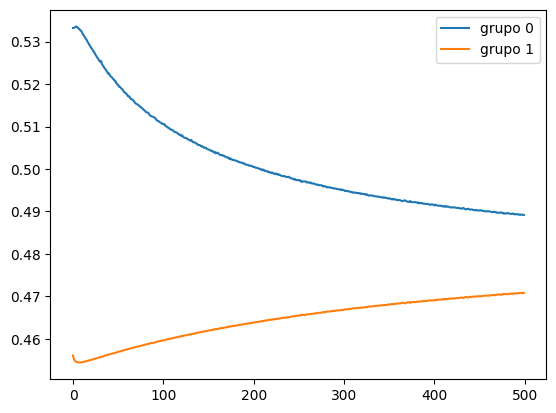

In [81]:
# Plot loss overtime:
size = len(weight_group0)
x = np.arange(0, size)

plt.plot(x, loss_group0, label='grupo 0')
plt.plot(x, loss_group1, label='grupo 1')

plt.legend()

plt.show()

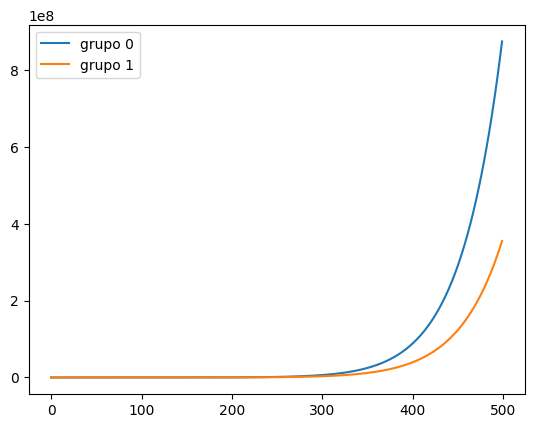

In [82]:
size = len(weight_group0)
x = np.arange(0, size)

plt.plot(x, weight_group0, label='grupo 0')
plt.plot(x, weight_group1, label='grupo 1')

plt.legend()

plt.show()

In [83]:
print(mm_model.eps)

0.026327688477341595
